# <CENTER>Tweet sentiment analysis</CENTER>

## TODO

- (Embedding tweet instead of google news)
- Add OLE on embedding (+2 into dim) **DONE**
- Add EV on embedding (+9 into dim)
- 
- Cross validation
- Comment vérifier l'overfitting? **DONE**
- Jouer avec hyperparametres (dropout, fonction activation, nb de neuronnes, nb de layers, nb d'epoche / batch, optimisation, architecture, 

## 0. Preparation

### Imports

In [22]:
# Python core and 3rd-party libraries
import numpy as np
import pandas as pd
import psutil # RAM monitoring

from matplotlib import pyplot as plt
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Our custom preprocessing module
from preprocessing import data_preprocessing, data_preprocessing_test

In [23]:
#from keras.layers import Bidirectional, Flatten, Input 

#import matplotlib as mpl
#from preprocessing import standardization, data_preprocessing
#mpl.use('TkAgg')  # or whatever other backend that you want

### Settings

In [24]:
np.random.seed(7) # random state

CORPUS_TRAIN_3 = "../data/tweet/data_train_3.csv" # training part of the corpus for the model with 3 output classes
CORPUS_TEST_3 = "../data/tweet/data_test_3.csv" # testing part of the corpus for the model with 3 output classes
CORPUS_TRAIN_7 = "../data/tweet/data_train_7.csv" # training part of the corpus for the model with 7 output classes

# FIXME: Currently, not available!
CORPUS_TEST_7 = CORPUS_TEST_3  # testing part of the corpus for the model with 7 output classes
#CORPUS_TEST_7 = "data/task_A/data_test_7.csv"

EMBEDDING_W2C_FILE = "../data/embedding/GoogleNews-vectors-negative300.bin" # Google word2vec's file (~3.5GB)
EMBEDDING_MATRIX_FILE = "../data/embedding/embedding_matrix.csv" # the embedding matrix exported to CSV (~200MB)
BASE_EMBEDDING_DIM = 300 # Embedding (word2vec) dimension

# FIXME
EXTRA_EMBEDDING_DIM = 2 + 9 # Add extra dimensions for polarities, etc
EMBEDDING_DIM = BASE_EMBEDDING_DIM + EXTRA_EMBEDDING_DIM # Total embedding dimensions

OLE_POSITIVE_PATH = "../resources/OLE/positive-words.txt"
OLE_NEGATIVE_PATH = "../resources/OLE/negative-words.txt"
EV_PATH = "../resources/EV/index.json"

# Required memory (in GB) to run this notebook smoothly
REQUIRED_MEMORY = 6

## 1. Preprocessing

### Preprocess the tweets

Example:

"Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates..." <BR>
-> "win match plus tomorrow busy day awareness day debate gulp debate ..."

**FIXME** for \*\_train_7: data_preprocessing(CORPUS_TRAIN_7, **'train'**) **???**

In [25]:
tweets_train_3, sentiments_train_3 = data_preprocessing(CORPUS_TRAIN_3, 'train')
tweets_train_7, sentiments_train_7 = data_preprocessing(CORPUS_TRAIN_7, 'test')

#FIXME 
#data = pd.read_csv("/home/abdou/Documents/datastories-semeval2017-task4-master/dataset/Subtask_A/gold/2018-Valence-oc-En-test-gold.txt", sep='\t', encoding='utf-8')
#tweets_test_7 = data_preprocessing_test(data)
tweets_test_7 = tweets_train_7

### Tokenize the tweets and get the word index

In [26]:
tokenizer = Tokenizer(filters=' ')
all_tweets = tweets_train_3.append(tweets_train_7) # append both Pandas series
tokenizer.fit_on_texts(all_tweets)
word_index = tokenizer.word_index # a dictionary {word: index}
len(word_index)

37785

### Create sequences

Example: "win match plus tomorrow busy day awareness day debate gulp debate ..." -> [43, 234, 769, 2, 1054, 6, 2896, 6, 424, 12301, 424, 1]

In [27]:
sequences_train_3 = tokenizer.texts_to_sequences(tweets_train_3)
sequences_train_7 = tokenizer.texts_to_sequences(tweets_train_7)
sequences_test_7 = tokenizer.texts_to_sequences(tweets_test_7)

### Calculate the max tweet sequence and pad data

In [28]:
MAX_SEQUENCE_LENGTH = max(len(elt) for elt in sequences_train_3 + sequences_train_7)
MAX_SEQUENCE_LENGTH

32

In [29]:
data_train_3 = pad_sequences(sequences_train_3, maxlen=MAX_SEQUENCE_LENGTH)
data_train_7 = pad_sequences(sequences_train_7, maxlen=MAX_SEQUENCE_LENGTH)
data_test_7 = pad_sequences(sequences_test_7, maxlen=MAX_SEQUENCE_LENGTH)

### Create OLE
positive word [1, 0], negative word [0, 1], neutral word [0, 0].

In [30]:
def get_OLE_matrix():
    # Create frame for OLE
    ole_frame = np.zeros((len(word_index) + 1, 2))

    # Get resources OLE (pos and neg)
    data_ole_pos = pd.read_csv(OLE_POSITIVE_PATH, sep=" ", header=None)
    data_ole_neg = pd.read_csv(OLE_NEGATIVE_PATH, sep=" ", header=None)

    # Transforme columns to list
    data_ole_pos = data_ole_pos[0].tolist()
    data_ole_neg = data_ole_neg[0].tolist()
    
    # Filling the ole_frame with flag value
    for word, i in word_index.items():
        if word in data_ole_pos:
            ole_frame[i] = [1, 0]
        elif word in data_ole_neg:
            ole_frame[i] = [0, 1]

    return ole_frame

### Create EV

In [31]:
def get_EV_matrix():
    # Create frame for EV
    ev_frame = np.zeros((len(word_index) + 1, 9))
    ev_frame.shape

    # Get resource EV
    data_ev = pd.read_json(EV_PATH)
    data_ev['polarity'] = data_ev['polarity'] + 4

    # Transforme columns to list
    col_name = data_ev['name'].tolist()
    col_emoji = data_ev['emoji'].tolist()
    col_polarity = data_ev['polarity'].tolist()
    
    # Filling the ev_frame with polarity
    for word, i in word_index.items():
        # The '' is for special encoding
        if ('️' + word in col_emoji) or (word + '️' in col_emoji) or (word in col_emoji):
            index_emoji = find_emoji_index(col_emoji, word)
            polarity_flag = col_polarity[index_emoji]   
            print("Word {} at {} pol {}".format(word, i, polarity_flag))
            ev_frame[i][polarity_flag] = 1 

    # i.e.:
    print(ev_frame[1541])
    
    return ev_frame

In [32]:
# Function that find the index of a given emoji
def find_emoji_index(col_emoji, word):
    index = -1
    try:
        index = col_emoji.index(word)
    except:
        try:
            index = col_emoji.index('️' + word)
        except:
            index = col_emoji.index(word + '️')
    return index

### Create the embedding matrix

In [33]:
psutil.virtual_memory()

svmem(total=8241573888, available=3154690048, percent=61.7, used=4282540032, free=1272233984, active=4905910272, inactive=1607577600, buffers=287879168, cached=2398920704, shared=514457600, slab=264396800)

In [34]:
def get_word2vec_matrix():
    # We need 1 extra line for OOV (out of vocabulary words)
    word2vec_matrix = np.zeros((len(word_index) + 1, BASE_EMBEDDING_DIM))

    # Replace the oov with a random embedding vector.
    oov = 2.0 * np.random.rand(BASE_EMBEDDING_DIM) - 1.0
    oov /= np.linalg.norm(oov)

    # Load the Google word2vec file. ** This is the RAM-consuming step! **
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_W2C_FILE, binary=True)
  
    # Fill the 300 first columns of the matrix from the Google word2vec file.
    # Replace the oov with a random embedding vector.
    for word, i in word_index.items():
        if word in word2vec.vocab:
            word2vec_matrix[i] = word2vec.word_vec(word)
        else:
            word2vec_matrix[i] = oov

    return word2vec_matrix

In [35]:
def get_embedding_matrix(generate_embedding_matrix=None):
  # Decide if we generate the embedding matrix from from the Google word2vec file,
  # our read it directly from a CSV file we created before
  
  if generate_embedding_matrix is None:
    # check if there is enough RAM available
    available_memory = psutil.virtual_memory().available
    generate_embedding_matrix = (available_memory >= REQUIRED_MEMORY * 2**30)
    
    # check if the Google word2vec file can be opened successfully
    try: 
      with open(EMBEDDING_W2C_FILE) as _: 
        pass
    except:
      print("Could not open the Google word2vec file")
      generate_embedding_matrix = False
    
  # Generate the embedding matrix using either method
  if generate_embedding_matrix:
    print("Generating the embedding matrix from the Google word2vec file and from OLE, please wait...")

    # Create and concetenate the word2vec and OLE parts. ** This is the RAM-consuming step! **
    embedding_matrix = np.hstack([get_word2vec_matrix(), get_OLE_matrix()])

    # Export the result to CSV using Pandas for future use on a less powerful computer
    pd.DataFrame(embedding_matrix).to_csv(EMBEDDING_MATRIX_FILE, header=False, index=False)
    print("Done.")
        
  else:
    # The CSV file mentioned here was created before as above, but on a more powerful computer
    print("Reading the embedding matrix from a CSV file of us... Done.") 

    # Import the embedding matrix from CSV using Pandas
    embedding_matrix = pd.read_csv(EMBEDDING_MATRIX_FILE, header=None)
    
  return embedding_matrix

In [36]:
embedding_matrix = get_embedding_matrix()

Reading the embedding matrix from a CSV file of us... Done.


In [37]:
embedding_matrix.shape

(37785, 300)

In [15]:
len(word_index)

37785

In [16]:
word_index.items()

dict_items([('...', 1), ('tomorrow', 2), ('not', 3), ('may', 4), ('go', 5), ('day', 6), ('get', 7), ('see', 8), ('night', 9), ('friday', 10), ('time', 11), ('like', 12), ('sunday', 13), ('1st', 14), ('come', 15), ('make', 16), ('watch', 17), ('saturday', 18), ('one', 19), ('u', 20), ('say', 21), ('game', 22), ('2nd', 23), ('new', 24), ('want', 25), ('monday', 26), ('think', 27), ('know', 28), ('today', 29), ('good', 30), ('would', 31), ('3rd', 32), ('no', 33), ('tonight', 34), ('play', 35), ('love', 36), ('..', 37), ('thursday', 38), ('back', 39), ('last', 40), ('take', 41), ('look', 42), ('win', 43), ('show', 44), ('still', 45), ('start', 46), ('sun', 47), ('best', 48), ('first', 49), ('️', 50), ('wait', 51), ('cannot', 52), ('david', 53), ('next', 54), ('happy', 55), ('4th', 56), ('big', 57), ('need', 58), ('tuesday', 59), ('work', 60), ('great', 61), ('year', 62), ('live', 63), ('☺', 64), ('right', 65), ('miss', 66), ('world', 67), ('morning', 68), ('well', 69), ('give', 70), ('v', 

### Create the dataset

In [9]:
# One-hot vectors
labels_train_3 = to_categorical(np.asarray(sentiments_train_3), 3) 
labels_train_7 = to_categorical(np.asarray(sentiments_train_7), 7)
print(labels_train_3.shape)
print(labels_train_7.shape)

(50333, 3)
(1630, 7)


In [26]:
# Create and split dataset_3
split_idx = int(len(data_train_3) * 0.70)

x_train_3, x_val_3 = data_train_3[:split_idx], data_train_3[split_idx:]
y_train_3, y_val_3 = labels_train_3[:split_idx], labels_train_3[split_idx:]

print('training set: ' + str(len(x_train_3)) + ' samples')
print('validation set: ' + str(len(x_val_3)) + ' samples')

print('x_train_3 shape: ', x_train_3.shape)
print('y_train_3 shape: ', y_train_3.shape)

dataset_3 = x_train_3, y_train_3, x_val_3, y_val_3 

training set: 35233 samples
validation set: 15100 samples
x_train_3 shape:  (35233, 32)
y_train_3 shape:  (35233, 3)


In [27]:
# Create and split dataset_7
split_idx = int(len(data_train_7) * 0.85)

x_train_7, x_val_7 = data_train_7[:split_idx], data_train_7[split_idx:]
y_train_7, y_val_7 = labels_train_7 [:split_idx], labels_train_7[split_idx:]

print('training set: ' + str(len(x_train_7)) + ' samples')
print('validation set: ' + str(len(x_val_7)) + ' samples')

print('x_train_7 shape: ', x_train_7.shape)
print('y_train_7 shape: ', y_train_7.shape)

dataset_7 = x_train_7, y_train_7, x_val_7, y_val_7 

training set: 1385 samples
validation set: 245 samples
x_train_7 shape:  (1385, 32)
y_train_7 shape:  (1385, 7)


## 2. Model training

### A model factory class

In [21]:
class Model:
  
  def build(self, layers, transferred_model):
    # set a new model
    if transferred_model is None: 
      self.model = Sequential()
    else:
      self.model = transferred_model
      
    # add/remove the layers
    for layer in layers:
      if layer[0] == 'Embedding':
        self.model.add(layer[1])
      if layer[0] == 'LSTM':
        self.model.add(LSTM(layer[1]))
      if layer[0] == 'GRU':
        self.model.add(GRU(layer[1]))
      if layer[0] == 'Dropout':
        self.model.add(Dropout(layer[1]))
      if layer[0] == 'Dense':
        self.model.add(Dense(layer[1], activation=layer[2]))
      if layer[0] == 'Cut':
        for _ in range(layer[1]):
          print("Cut")
          self.model.layers.pop()
    
    # compile the model, and show its summary
    self.model.compile(loss=self.hp['loss'],
                  optimizer=self.hp['optimizer'],
                  metrics=self.hp['metrics'])
    self.model.summary()
  
  def __init__(self, dataset, layers, hyperparameters, transferred_model=None):
    self.x_train, self. y_train, self.x_val, self.y_val = dataset
    self.hp = hyperparameters
    self.build(layers, transferred_model) # build the model (set self.model accordingly)

    
  def fit(self):
    self.history = self.model.fit(self.x_train, self.y_train, validation_data=(self.x_val, self.y_val),
                                  epochs=self.hp['epochs'], batch_size=self.hp['batch_size'])

  def cross_validate(self, n_folds=10):
    '''
    Fit the model, using k-fold cross-validation (k = n_folds if n_fold != None),
    or on the whole training set (if n_fold == None).
    '''
    x, y = self.dataset

    print("\nStart cross-validation")
    history = []
    n = x.shape[0]
    # we must use the same weights for each fold of cross-validation, so we save them
    Wsave = self.model.get_weights()  

    for i in range(n_folds): # i = current fold index
        print("\nFold {}/{}".format(i + 1, n_folds))

        # split the data into train and validation parts for the i-th fold 
        idx1, idx2 = int((i/n_folds)*n), int(((i+1)/n_folds)*n)
        slice1, slice2, slice3 = slice(0, idx1), slice(idx1, idx2), slice(idx2, n)
        x_train = np.vstack([x[slice1, :], x[slice3, :]])
        y_train = np.vstack([y[slice1, :], y[slice3, :]])
        x_val, y_val = x[slice2, :], y[slice2, :]

        # train the model for the i-th fold
        self.model.set_weights(Wsave) #restore the old weights 
        history.append(self.model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                  epochs=self.hp['epochs'], batch_size=self.hp['batch_size']))

    self.model.set_weights(Wsave) #restore the old weights
        
    # Compute the optimal number of epochs
    val_accs = np.array([history[i].history['val_acc'] for i in range(n_folds)])
    val_losses = np.array([history[i].history['val_loss'] for i in range(n_folds)])

    return val_accs, val_losses

  def cross_validate(self, n_folds=10):
        '''
        Fit the model, using k-fold cross-validation (k = n_folds if n_fold != None),
        or on the whole training set (if n_fold == None).
        '''
        x, y = self.dataset

        print("\nStart cross-validation")
        history = []
        n = x.shape[0]
        # we must use the same weights for each fold of cross-validation, so we save them
        Wsave = self.model.get_weights()  

        for i in range(n_folds): # i = current fold index
            print("\nFold {}/{}".format(i + 1, n_folds))

            # split the data into train and validation parts for the i-th fold 
            idx1, idx2 = int((i/n_folds)*n), int(((i+1)/n_folds)*n)
            slice1, slice2, slice3 = slice(0, idx1), slice(idx1, idx2), slice(idx2, n)
            x_train = np.vstack([x[slice1, :], x[slice3, :]])
            y_train = np.vstack([y[slice1, :], y[slice3, :]])
            x_val, y_val = x[slice2, :], y[slice2, :]

            # train the model for the i-th fold
            self.model.set_weights(Wsave) #restore the old weights 
            history.append(self.model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                      epochs=self.hp['epochs'], batch_size=self.hp['batch_size']))

            self.model.set_weights(Wsave) #restore the old weights

        val_accs = np.array([history[i].history['val_acc'] for i in range(n_folds)])
        return val_accs

  def plot_learning_loss(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    #plt.save("../results/")

  def plot_learning_acc(self):  
    plt.plot(self.history.history['acc'])
    plt.plot(self.history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

  def predict(self, data_test):
     self.model.predict(data_test)
    
  def save(self, path):
    self.model.save(path)

### Create the embedding layer

In [32]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            name='embedding_layer')

### Model training on dataset_3

#### Model 1

In [37]:
# Model 1
layers_1 = [
  ('Embedding', embedding_layer),
  ('LSTM', 32),
  ('Dropout', 0.2),
  ('Dense', 32, 'relu'),
  ('Dropout', 0.2),
  ('Dense', 3, 'softmax')
]

hyperparameters_1 = {
  'loss': 'categorical_crossentropy',
  'optimizer': 'Adam', 
  'metrics': ['acc'],
  'epochs': 20,
  'batch_size': 50 
}

model1 = Model(dataset_3, layers_1, hyperparameters_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 311)           11751446  
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                44032     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 11,796,633
Trainable params: 45,187
Non-trainable params: 11,751,446
___________________________________________________________

In [38]:
# Model call (training + save)
model1.fit()
model1.save("../results/models/model1_semidense_ole_ev.h5")

Train on 35233 samples, validate on 15100 samples
Epoch 1/20
35233/35233 [==============================] - 17s 487us/step - loss: 0.8931 - acc: 0.5696 - val_loss: 0.8908 - val_acc: 0.5521
Epoch 2/20
35233/35233 [==============================] - 17s 473us/step - loss: 0.8077 - acc: 0.6292 - val_loss: 0.8662 - val_acc: 0.5793
Epoch 3/20
35233/35233 [==============================] - 16s 466us/step - loss: 0.7793 - acc: 0.6446 - val_loss: 0.8720 - val_acc: 0.5727
Epoch 4/20
35233/35233 [==============================] - 16s 465us/step - loss: 0.7581 - acc: 0.6552 - val_loss: 0.8756 - val_acc: 0.5815
Epoch 5/20
35233/35233 [==============================] - 16s 462us/step - loss: 0.7400 - acc: 0.6684 - val_loss: 0.8540 - val_acc: 0.5864
Epoch 6/20
35233/35233 [==============================] - 17s 492us/step - loss: 0.7224 - acc: 0.6760 - val_loss: 0.8592 - val_acc: 0.5897
Epoch 7/20
35233/35233 [==============================] - 16s 466us/step - loss: 0.7029 - acc: 0.6840 - val_loss: 0.

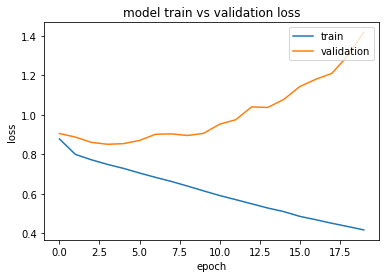

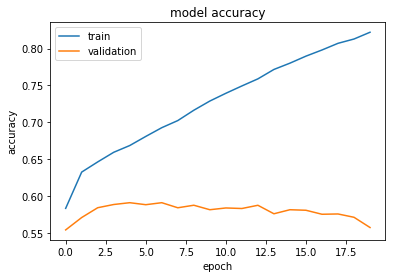

In [36]:
model1.plot_learning_loss()
model1.plot_learning_acc()

#### Model 2

In [20]:
# Model 2
layers_2 = [
  ('Embedding', embedding_layer),
  ('GRU', 32),
  ('Dropout', 0.2),
  ('Dense', 3, 'softmax')
]

hyperparameters_2 = {
  'loss': 'categorical_crossentropy',
  'optimizer': 'rmsprop', 
  'metrics': ['acc'],
  'epochs': 6,
  'batch_size': 50 
}

model2 = Model(dataset_3, layers_2, hyperparameters_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                31968     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 11,367,567
Trainable params: 32,067
Non-trainable params: 11,335,500
_________________________________________________________________


### Model training on dataset_7 by transfer learning

In [22]:
# Model built from transfer learning

transferred_model = load_model("./model1.h5") #or: model1.model
transferred_model.summary()

layers = [
  ('Cut', 2),
  ('Dense', 150, 'relu'),
  ('Dense', 64, 'relu'),
  ('Dense', 7, 'softmax'),
]

hyperparameters = {
  'loss': 'categorical_crossentropy',
  'optimizer': 'rmsprop', 
  'metrics': ['acc'],
  'epochs': 11,
  'batch_size': 50
}

model = Model(dataset_7, layers, hyperparameters, transferred_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 11,379,279
Trainable params: 43,779
Non-trainable params: 11,335,500
___________________________________________________________

In [21]:
model.fit()
model.save("./model3.h5")

Train on 1385 samples, validate on 245 samples
Epoch 1/11
1385/1385 [==============================] - 3s 2ms/step - loss: 1.8253 - acc: 0.2780 - val_loss: 1.7866 - val_acc: 0.2571
Epoch 2/11
1385/1385 [==============================] - 1s 849us/step - loss: 1.7004 - acc: 0.3329 - val_loss: 1.7166 - val_acc: 0.2694
Epoch 3/11
1385/1385 [==============================] - 1s 869us/step - loss: 1.6408 - acc: 0.3466 - val_loss: 1.7067 - val_acc: 0.2776
Epoch 4/11
1385/1385 [==============================] - 1s 859us/step - loss: 1.6067 - acc: 0.3466 - val_loss: 1.7022 - val_acc: 0.2735
Epoch 5/11
1385/1385 [==============================] - 1s 866us/step - loss: 1.5878 - acc: 0.3523 - val_loss: 1.6929 - val_acc: 0.2776
Epoch 6/11
1385/1385 [==============================] - 1s 882us/step - loss: 1.5578 - acc: 0.3639 - val_loss: 1.6797 - val_acc: 0.2735
Epoch 7/11
1385/1385 [==============================] - 1s 874us/step - loss: 1.5459 - acc: 0.3755 - val_loss: 1.6768 - val_acc: 0.3429
Epo

## 3. Model testing

In [22]:
r = model.predict(data_test_7)

conclusions = ["-1: slightly negative emotional state can be inferred",
               "-2: moderately negative emotional state can be inferred",
               "-3: very negative emotional state can be inferred",
               "0: neutral or mixed emotional state can be inferred",
               "1: slightly positive emotional state can be inferred",
               "2: moderately positive emotional state can be inferred",
               "3: very positive emotional state can be inferred"]

for i in range(len(r)):
    data['Intensity Class'][i] = conclusions[numpy.argmax(r[i])]

TypeError: object of type 'NoneType' has no len()

### Write predictions

In [ ]:
#FIXME: write predictions with Pandas instead

with open("./submission_after.csv", "w") as f:
  f.write("ID\tTweet\tAffect Dimension\tIntensity Class\n")
  for d in range(len(data)):
    f.write(data['ID'][d] + "\t" + data['Tweet'][d] + "\tvalence\t" + data['Intensity Class'][d] + "\n")

In [2]:
model = load_model("./model1.h5")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 11,379,279
Trainable params: 43,779
Non-trainable params: 11,335,500
___________________________________________________________

In [3]:
model.layers.pop()
model.layers.pop()

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 11,379,279
Trainable params: 43,779
Non-trainable params: 11,335,500
___________________________________________________________

In [5]:
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 11,379,279
Trainable params: 43,779
Non-trainable params: 11,335,500
___________________________________________________________

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 300)           11335500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 11,379,279
Trainable params: 43,779
Non-trainable params: 11,335,500
___________________________________________________________